In [1]:
from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph

memory = MemorySaver()

def reducer(a: list, b: int | None) -> int:
    if b is not None:
        return a + [b]
    return a

class State(TypedDict):
    x: Annotated[list, reducer]

class ConfigSchema(TypedDict):
    r: float

graph = StateGraph(State, config_schema=ConfigSchema)

def node(state: State, config: RunnableConfig) -> dict:
    r = config["configurable"].get("r", 1.0)
    x = state["x"][-1]
    next_value = x * r * (1 - x)
    return {"x": next_value}

graph.add_node("A", node)
graph.set_entry_point("A")
graph.set_finish_point("A")
compiled = graph.compile(checkpointer=memory)

print(compiled.config_specs)




[ConfigurableFieldSpec(id='r', annotation=<class 'float'>, name=None, description=None, default=None, is_shared=False, dependencies=None), ConfigurableFieldSpec(id='thread_id', annotation=<class 'str'>, name='Thread ID', description=None, default='', is_shared=True, dependencies=None), ConfigurableFieldSpec(id='thread_ts', annotation=typing.Optional[str], name='Thread Timestamp', description='Pass to fetch a past checkpoint. If None, fetches the latest checkpoint.', default=None, is_shared=True, dependencies=None)]


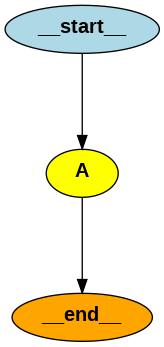

In [2]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

In [3]:

config = {"configurable": {"thread_id": "conversation_1", "r": 4.0}}


step1 = compiled.invoke({"x": 0.5}, config=config)
print(step1)

{'x': [0.5, 1.0]}


In [4]:
final_state = compiled.get_state(config)
print("Final state:", final_state)

Final state: StateSnapshot(values={'x': [0.5, 1.0]}, next=(), config={'configurable': {'thread_id': 'conversation_1', 'thread_ts': '1ef5d5c2-9d0e-6351-8001-974e356ea534'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'A': {'x': 1.0}}}, created_at='2024-08-18T12:19:49.170443+00:00', parent_config=None)


## Message Graph

In [5]:
from langgraph.graph.message import MessageGraph, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage


In [6]:
builder = MessageGraph()


class ExternalService:
    def search(query: str):
        return "found!"

def hello_node(state):
    " say hello "
    return [AIMessage(
        content="Hello!",
        tool_calls=[{"name": "search", "id": "123", "args": {"query": "X"}}],
    )]
    

def create_search_tool_with_external(service: ExternalService):

    def search_tool(state):
        result = service.search()
        return [ToolMessage(
            content=f"Searching...  {result}", 
            tool_call_id="123"
        )]

    return search_tool        
    

def result_node(state):
    return [AIMessage(
        content="Done searching!"
    )]
    
def router(state):
    if state[-1].tool_calls:
        return "search_tool"
    return "END"
    

builder.add_node(hello_node)
builder.add_node(create_search_tool_with_external(ExternalService()))
builder.add_node(result_node)

builder.set_entry_point("hello_node")

builder.add_conditional_edges(
    "hello_node",
    router
)

builder.add_edge("search_tool", "result_node")

builder.set_finish_point("result_node")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

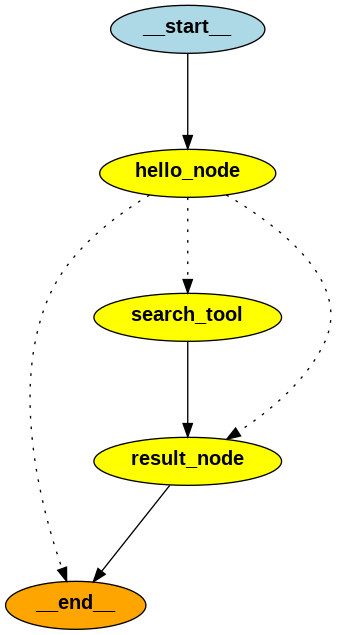

In [7]:
Image(graph.get_graph().draw_png())

In [8]:
config1 = {"configurable": {"thread_id": "conversation_1"}}

graph.invoke([HumanMessage(content="Hi There!")], config=config1)

[HumanMessage(content='Hi There!', id='e0aa4937-2592-4c5b-9a99-b53ca49d657f'),
 AIMessage(content='Hello!', id='ea9515fb-966d-4e76-a929-948853b453be', tool_calls=[{'name': 'search', 'args': {'query': 'X'}, 'id': '123', 'type': 'tool_call'}]),
 ToolMessage(content='Searching...  found!', id='975065b9-7f98-4bbb-831a-0d41ffb03cce', tool_call_id='123'),
 AIMessage(content='Done searching!', id='0a4a9adc-702c-4fa8-a3b4-fd64bf352967')]

In [9]:
config1

{'configurable': {'thread_id': 'conversation_1'}}

In [10]:
config2 = {"configurable": {"thread_id": "conversation_2"}}

graph.invoke([HumanMessage(content="Hi There!")], config=config2)

[HumanMessage(content='Hi There!', id='e814bd5b-336e-40b3-bf9e-d762ed1413a7'),
 AIMessage(content='Hello!', id='327825b1-b322-489f-bbef-9509d1b7fae1', tool_calls=[{'name': 'search', 'args': {'query': 'X'}, 'id': '123', 'type': 'tool_call'}]),
 ToolMessage(content='Searching...  found!', id='1b0b479e-8acf-4719-8a07-836c3791df2a', tool_call_id='123'),
 AIMessage(content='Done searching!', id='d8b87013-4791-4d9d-b207-949ba9ffee8f')]

In [13]:
graph.get_state(config2)

StateSnapshot(values=[HumanMessage(content='Hi There!', id='e814bd5b-336e-40b3-bf9e-d762ed1413a7'), AIMessage(content='Hello!', id='327825b1-b322-489f-bbef-9509d1b7fae1', tool_calls=[{'name': 'search', 'args': {'query': 'X'}, 'id': '123', 'type': 'tool_call'}]), ToolMessage(content='Searching...  found!', id='1b0b479e-8acf-4719-8a07-836c3791df2a', tool_call_id='123'), AIMessage(content='Done searching!', id='d8b87013-4791-4d9d-b207-949ba9ffee8f')], next=(), config={'configurable': {'thread_id': 'conversation_2', 'thread_ts': '1ef5d5c2-9fde-65b8-8003-515c096ba5c5'}}, metadata={'source': 'loop', 'step': 3, 'writes': {'result_node': [AIMessage(content='Done searching!', id='d8b87013-4791-4d9d-b207-949ba9ffee8f')]}}, created_at='2024-08-18T12:19:49.465402+00:00', parent_config=None)

In [15]:
for h in graph.get_state_history(config2):
    print(h)

StateSnapshot(values=[], next=('__start__',), config={'configurable': {'thread_id': 'conversation_2', 'thread_ts': '1ef5d5c2-9fb4-6268-bfff-634c6b5e0761'}}, metadata={'source': 'input', 'step': -1, 'writes': [HumanMessage(content='Hi There!')]}, created_at='2024-08-18T12:19:49.448123+00:00', parent_config=None)
StateSnapshot(values=[HumanMessage(content='Hi There!', id='e814bd5b-336e-40b3-bf9e-d762ed1413a7')], next=('hello_node',), config={'configurable': {'thread_id': 'conversation_2', 'thread_ts': '1ef5d5c2-9fb9-6870-8000-f38aea39349f'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2024-08-18T12:19:49.450322+00:00', parent_config=None)
StateSnapshot(values=[HumanMessage(content='Hi There!', id='e814bd5b-336e-40b3-bf9e-d762ed1413a7'), AIMessage(content='Hello!', id='327825b1-b322-489f-bbef-9509d1b7fae1', tool_calls=[{'name': 'search', 'args': {'query': 'X'}, 'id': '123', 'type': 'tool_call'}])], next=('search_tool',), config={'configurable': {'thread_id': 'conv

In [16]:
for update in graph.stream([HumanMessage(content="Hi There!")], config={"configurable": {"thread_id": "conversation_3"}}):
    print(update)

{'hello_node': [AIMessage(content='Hello!', id='b8ddc668-a651-4956-92cb-4a0e01ae9d16', tool_calls=[{'name': 'search', 'args': {'query': 'X'}, 'id': '123', 'type': 'tool_call'}])]}
{'search_tool': [ToolMessage(content='Searching...  found!', tool_call_id='123')]}
{'result_node': [AIMessage(content='Done searching!')]}
